In [12]:
import csv
import xml.etree.ElementTree as ET
from datetime import datetime, timezone, timedelta

def scrapeRawData(fileName, setTag = ""):
    tree = ET.parse(fileName)
    records = tree.getroot()
    entries = []

    for result in records:
        # Traverse headers
        header = result.find('header')
        infoMaster = header.find('controlInfo')

        artInfo = infoMaster.find('artinfo')
        # Get title     
        tig = artInfo.find('tig')
        title = tig.find('atl').text
        
        # Get author
        aug = artInfo.find('aug')
        aus = aug.findall('au')
        authors = []
        for au in aus:
            authors.append(au.text)
        
        
        # Get journal names
        jInfo = infoMaster.find('jinfo')
        journalName = jInfo.find('jtl').text
    
        # get language
        language = infoMaster.find('language').text
        
        # Get publication info
        pubInfo = infoMaster.find('pubinfo')
        dt = pubInfo.find('dt')
        att = dt.attrib
        year = att.get('year')
        month = att.get('month')
        day = att.get('day')
        date = datetime(int(year), int(month), int(day)).date()
        
        # Pack results into entries
        entry = {'setTag': setTag,
                'title': title,
                'authors': authors,
                'datePublished': date,
                'authors': authors,
                'language': language,
                'journalName': journalName}
        
        entries.append(entry)
    return entries

import csv
import io
def writeCSV(outFileName, entries):
    with io.open(outFileName,'w', encoding="utf-8", newline = '') as out:
        csv_out=csv.writer(out)
    
        csv_out.writerow(['setTag',
                          'title',
                          'authors',
                          'datePublished',
                          'language',
                          'journalName'])
        for entry in entries:
            authors = '. '.join(entry['authors'])
            row = [entry['setTag'], 
                   entry['title'], 
                   authors,
                   entry['datePublished'],
                   entry['language'],
                   entry['journalName']]
            csv_out.writerow(row)

def buildDailyPublishCount(entries):
    # Build sum by date
    dailyCount = {}
    for entry in entries:
        # Get the current date
        date = entry['datePublished']
        
        # Intiialize a sum if necessary
        if not date in dailyCount:
            dailyCount[date] = 0
            
        # Add to the daily sum
        dailyCount[date] += 1 

    return dailyCount

import matplotlib.dates as dates
import matplotlib.pyplot as plt
import os
def plotDayData(dayData, ylabel="Data", xlabel="Date", title="Daily Data", todayCol = '', maxCol = '', dayLimiter = 30, fmt = 'bo', saveFmt = ''):
    today = datetime.now().date()

    # Break dictionary into key list 
    days = list(dayData.keys())
    values = list(dayData.values())
    
    # Plot result
    plt.plot_date(days, values,fmt=fmt, tz=None, xdate=True)
    
    # Mark today with a vertical line
    if not todayCol == '':
        plt.axvline(x=today, color = todayCol, label = str(today))
        plt.legend()
    if not maxCol == '':
        plt.axhline(y=max(values), color = 'b', label = str(max(values)))
        plt.legend()
    # Limit plot to be within $dayLimiter days of today
    axes = plt.gca()
    axes.set_xlim([min(days), today + timedelta(days=dayLimiter)])
    
    # Label and show plot
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    if not saveFmt == '':
        fname = 'Images' + os.path.sep + title.replace(' ', '_') + '.' + saveFmt
        plt.savefig(fname = fname, format=saveFmt)
    
    plt.show()
def buildDailyPublishSum(dailyCount):
    dailySum = {}
    # For each day
    for date in dailyCount:
        # Sum all previous day counts
        for prevDate in dailyCount:
            # If this date is before or on the current date, 
            if prevDate <= date:
                # Initialize if necessary and add to sum
                if not date in dailySum:
                    dailySum[date] = 0
                dailySum[date] += dailyCount[prevDate]
    return dailySum

scraped  2196  publications


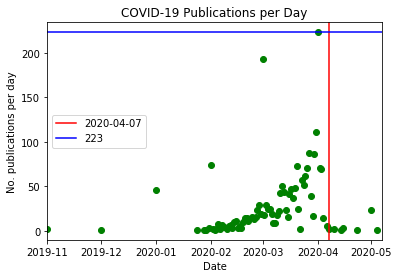

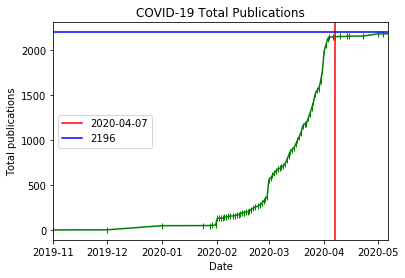

In [13]:
entries = scrapeRawData("rawData.xml", "COVID-19");
writeCSV('csvData.csv', entries);
print("scraped ", len(entries), " publications")

dailyCount = buildDailyPublishCount(entries)
plotDayData(dailyCount, 
            ylabel = "No. publications per day", 
            title = "COVID-19 Publications per Day", 
            todayCol = 'r', 
            maxCol = 'b', 
            fmt = 'go',
            saveFmt = 'svg')

dailySum = buildDailyPublishSum(dailyCount)
plotDayData(dailySum, 
            ylabel = "Total publications", 
            title = "COVID-19 Total Publications", 
            todayCol = 'r', 
            maxCol = 'b', 
            fmt = '|g-',
            saveFmt = 'svg')
